In [1]:
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
import utils
import sys, importlib

from matplotlib import rc
# for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

importlib.reload(sys.modules['utils'])
get_sequences = utils.get_sequences
convert_bagsize_key = utils.convert_bagsize_key
parse_json = utils.parse_json
get_plot_defaults = utils.get_plot_defaults
make_like_colab = utils.make_like_colab

out = '../plots'
if not os.path.isdir(out):
    os.makedirs(out)

defaults = get_plot_defaults()
print(defaults)

{'font_size_title': 32, 'font_size_axes': 25, 'font_size_ticks': 22, 'font_size_legend': 22, 'line_width': 3, 'marker_size': 10, 'dpi': 600}


In [2]:
results = {}

methods = {
}

methods = {
    'cmp-degensac-f': 'DEGENSAC',
    'nodegen': 'PyRANSAC',
    'cv2-ransac-f': 'OpenCV RANSAC',
    'cv2-usacaccurate-f': 'OpenCV USAC\_ACCURATE',
    'cv2-usacdef-f': 'OpenCV USAC\_DEFAULT',
    'cv2-usacfast-f': 'OpenCV USAC\_FAST',
    'cv2-usacmagsac-f': 'OpenCV USAC\_MAGSAC',
}



max_iters =  []
for j in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    for i in [1, 2, 5]:
        max_iters.append(j*i)
for i in range(len(methods)):
    method = list(methods.keys())[i]
    for max_iter in max_iters:
        key = '{}, max_iter={}'.format(method, max_iter)
        fname = os.path.join(
            'new_logs',
            f'tuning--{method}-iter-{max_iter}.json')
        try:
            results[key] = parse_json(fname)
        except Exception as e:
            print (e)
            print('Missing {}, {}'.format(method, max_iter))
            pass

[Errno 2] No such file or directory: 'new_logs/tuning--cmp-degensac-f-iter-10000000.json'
Missing cmp-degensac-f, 10000000
[Errno 2] No such file or directory: 'new_logs/tuning--cmp-degensac-f-iter-20000000.json'
Missing cmp-degensac-f, 20000000
[Errno 2] No such file or directory: 'new_logs/tuning--cmp-degensac-f-iter-50000000.json'
Missing cmp-degensac-f, 50000000
[Errno 2] No such file or directory: 'new_logs/tuning--cv2-ransac-f-iter-10000000.json'
Missing cv2-ransac-f, 10000000
[Errno 2] No such file or directory: 'new_logs/tuning--cv2-ransac-f-iter-20000000.json'
Missing cv2-ransac-f, 20000000
[Errno 2] No such file or directory: 'new_logs/tuning--cv2-ransac-f-iter-50000000.json'
Missing cv2-ransac-f, 50000000
[Errno 2] No such file or directory: 'new_logs/tuning--cv2-usacmagsac-f-iter-10000000.json'
Missing cv2-usacmagsac-f, 10000000
[Errno 2] No such file or directory: 'new_logs/tuning--cv2-usacmagsac-f-iter-20000000.json'
Missing cv2-usacmagsac-f, 20000000
[Errno 2] No such fi

In [6]:
for k,v in methods.items():
    print (v)
    #print ()
    #break

DEGENSAC
PyRANSAC
OpenCV RANSAC
OpenCV USAC\_ACCURATE
OpenCV USAC\_DEFAULT
OpenCV USAC\_FAST
OpenCV USAC\_MAGSAC


cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f
cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


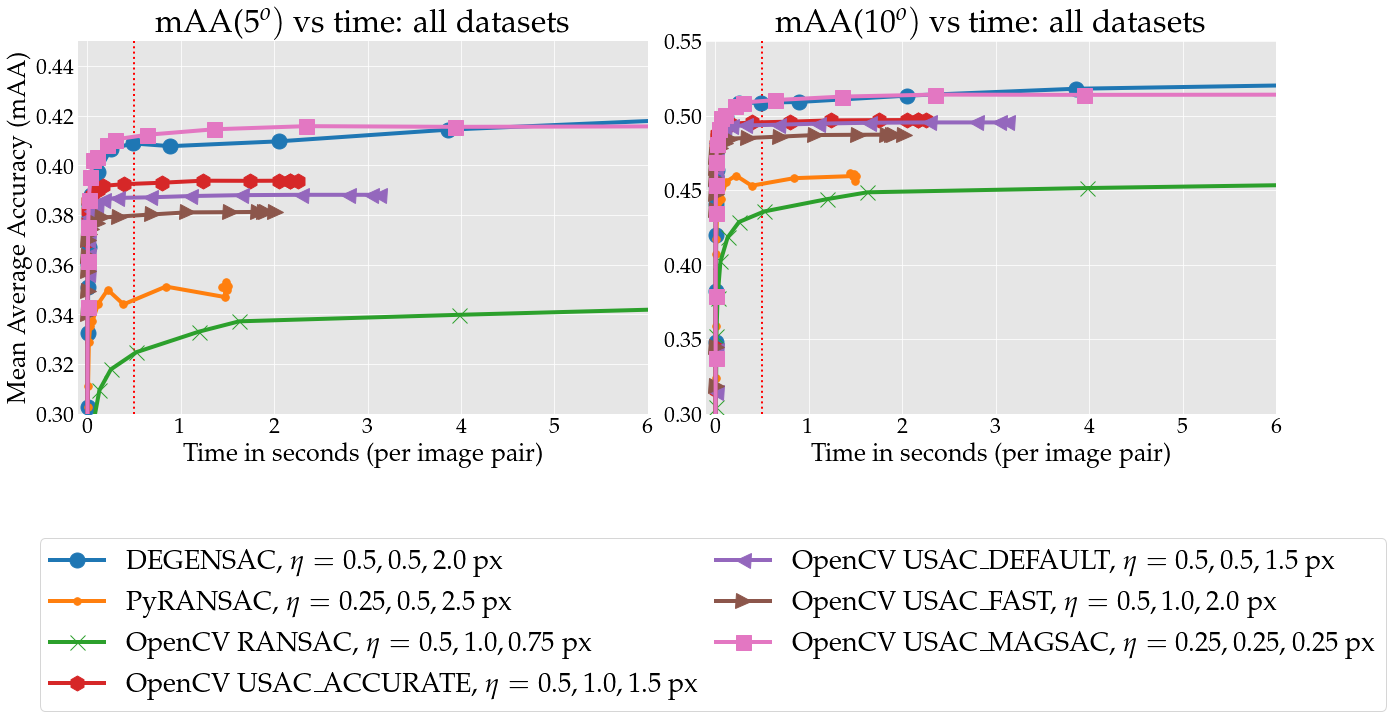

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('Dark2')
datasets = ['phototourism', 'googleurban', 'pragueparks']
markers = ['o', '.', 'x', 'h', '<', '>', 's']
feedback = {}
for cur, t in enumerate([5, 10]):
    ax = axes[cur]
    labels = []
    time_threshold = 0.5
    count = 0
    for i, method in enumerate(methods):
        cur_best_index, cur_best_val, cur_best_th, cur_best_t, best_map10 = -1, 0, 0, 0, 0
        x, y = [], []
        for j, max_iter in enumerate(max_iters):
            key = '{}, max_iter={}'.format(method, max_iter)
            if key in results:
                th = ''
                t_geom = 0
                v_map5 = 0
                v_map10 = 0
                for oo, dset in enumerate(datasets):
                    th += str(results[key]['config'][f'config_{dset}_stereo']['geom']['threshold'])
                    if oo < 2:
                        th+=', '
                    t_geom += results[key][dset]['results']['allseq']['stereo']['run_avg']['geom_cost']['mean']

                    v_map5 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_05_th_0.1']['mean']
                    v_map10 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_10_th_0.1']['mean']
                t_geom = t_geom / float(len(datasets))
                v_map5 = v_map5 / float(len(datasets))
                v_map10 = v_map10 / float(len(datasets))
                
                x.append(t_geom)
                y.append(v_map10 if t == 10 else v_map5)

                if cur == 0 and (v_map5 + v_map10) / 2 > cur_best_val and t_geom < time_threshold:
                    cur_best_index = j
                    cur_best_val = (v_map5 + v_map10) / 2
                    cur_best_map10 = v_map10
                    cur_best_t = t_geom
                    cur_best_th = th
        if len(x) > 0:
            ax.plot(x, y, '-', marker=markers[i], markersize=15, c=cmap(count), linewidth=defaults['line_width'] + 1)
            # cur_label = '{} ({})'.format(key.split(',')[0], key.split(',')[1][1:])
            kkey = key.split(',')[0]
            print (kkey)
            cur_label = methods[kkey]
            cur_th = float(key.split(',')[1][1:].split('=')[-1])
            cur_label = '{}, $\\eta={}$ px'.format(cur_label, th)
            labels.append(cur_label)
            count += 1
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title('mAA({}$^o)$ vs time: all datasets'.format(t), fontsize=defaults['font_size_title'], pad=10)
    ax.set_xlabel('Time in seconds (per image pair)', fontsize=defaults['font_size_axes'])
    if t == 5:
        ax.set_ylabel('Mean Average Accuracy (mAA)', fontsize=defaults['font_size_axes'])
    ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])

    lims = (0.3, 0.55)  if t == 10 else (0.3, 0.45)
#     lims = (0.45, 0.71)
    ax.set_ylim(lims)
    ax.vlines(0.5, lims[0], lims[1], lw=2, color='r', linestyle=':')
    ax.set_xlim(-0.10, 6)
    make_like_colab(fig, ax)

for i in sorted(feedback.keys())[::-1]:
    print(feedback[i])
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.42)
fig.legend(labels, prop={'size': defaults['font_size_legend'] + 5}, columnspacing=0.67, loc='lower center', bbox_to_anchor=(0.55, -0.01), ncol=2)
plt.savefig('sac-map-vs-cost-both-maps-ALL_DATASETS.pdf', bbox_inches='tight', dpi=defaults['dpi'])
plt.show()

Best results < 0.5 sec for DEGENSAC, $\eta=0.5, 0.5, 2.0$ px: mAA = 0.4588, n_iters= 100000
Best results < 0.5 sec for PyRANSAC, $\eta=0.25, 0.5, 2.5$ px: mAA = 0.4049, n_iters= 100000
Best results < 0.5 sec for OpenCV RANSAC, $\eta=0.5, 1.0, 0.75$ px: mAA = 0.3732, n_iters= 10000
Best results < 0.5 sec for OpenCV USAC\_ACCURATE, $\eta=0.5, 1.0, 1.5$ px: mAA = 0.4439, n_iters= 200000
Best results < 0.5 sec for OpenCV USAC\_DEFAULT, $\eta=0.5, 0.5, 1.5$ px: mAA = 0.4401, n_iters= 200000
Best results < 0.5 sec for OpenCV USAC\_FAST, $\eta=0.5, 1.0, 2.0$ px: mAA = 0.4322, n_iters= 200000
Best results < 0.5 sec for OpenCV USAC\_MAGSAC, $\eta=0.25, 0.25, 0.25$ px: mAA = 0.4596, n_iters= 100000


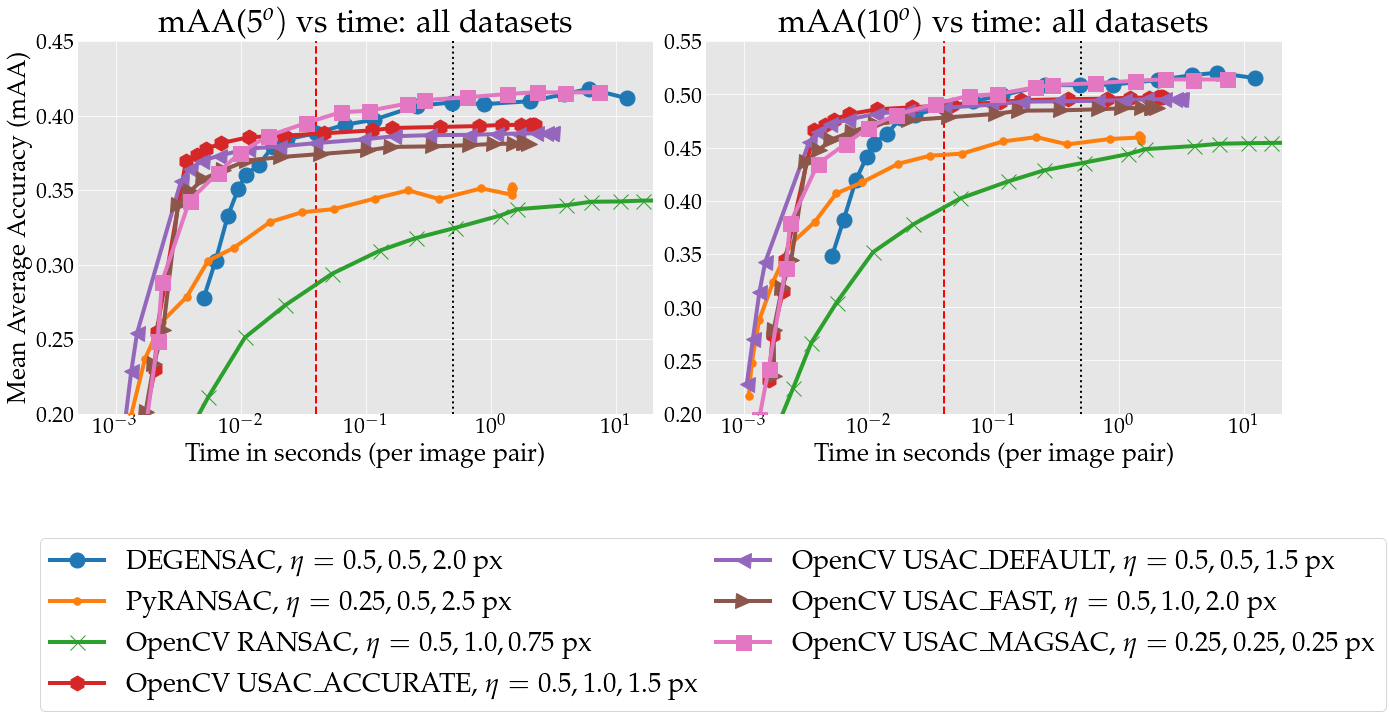

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('Dark2')
datasets = ['phototourism', 'googleurban', 'pragueparks']

feedback = {}
for cur, t in enumerate([5, 10]):
    ax = axes[cur]
    labels = []
    time_threshold = 0.5
    count = 0
    for i, method in enumerate(methods):
        cur_best_index, cur_best_val, cur_best_th, cur_best_t, best_map10 = -1, 0, 0, 0, 0
        x, y = [], []
        for j, max_iter in enumerate(max_iters):
            key = '{}, max_iter={}'.format(method, max_iter)
            if key in results:
                th = ''
                t_geom = 0
                v_map5 = 0
                v_map10 = 0
                for oo, dset in enumerate(datasets):
                    th += str(results[key]['config'][f'config_{dset}_stereo']['geom']['threshold'])
                    if oo < 2:
                        th+=', '
                    t_geom += results[key][dset]['results']['allseq']['stereo']['run_avg']['geom_cost']['mean']

                    v_map5 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_05_th_0.1']['mean']
                    v_map10 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_10_th_0.1']['mean']
                t_geom = t_geom / float(len(datasets))
                v_map5 = v_map5 / float(len(datasets))
                v_map10 = v_map10 / float(len(datasets))
                
                x.append(t_geom)
                y.append(v_map10 if t == 10 else v_map5)

                if cur == 0 and (v_map5 + v_map10) / 2 > cur_best_val and t_geom < time_threshold:
                    cur_best_index = j
                    cur_best_val = (v_map5 + v_map10) / 2
                    cur_best_map10 = v_map10
                    cur_best_t = t_geom
                    cur_best_th = th
        if len(x) > 0:
            ax.semilogx(x, y, '-', marker=markers[i], markersize=15, c=cmap(count), linewidth=defaults['line_width'] + 1)
            # cur_label = '{} ({})'.format(key.split(',')[0], key.split(',')[1][1:])
            kkey = key.split(',')[0]
            #print (kkey)
            cur_label = methods[kkey]
            cur_th = float(key.split(',')[1][1:].split('=')[-1])
            cur_label = '{}, $\\eta={}$ px'.format(cur_label, th)
            labels.append(cur_label)
            count += 1
            if cur == 0:
                print (f"Best results < 0.5 sec for {cur_label}: mAA = {cur_best_val:.4f}, n_iters= {max_iters[cur_best_index]}")
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title('mAA({}$^o)$ vs time: all datasets'.format(t), fontsize=defaults['font_size_title'], pad=10)
    ax.set_xlabel('Time in seconds (per image pair)', fontsize=defaults['font_size_axes'])
    if t == 5:
        ax.set_ylabel('Mean Average Accuracy (mAA)', fontsize=defaults['font_size_axes'])
    ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])

    lims = (0.2, 0.55)  if t == 10 else (0.2, 0.45)
#     lims = (0.45, 0.71)
    ax.set_ylim(lims)
    ax.vlines(0.5, lims[0], lims[1], lw=2, color='k', linestyle=':')
    ax.vlines(1.0/25., lims[0], lims[1], lw=2, color='r', linestyle='--')
    
#     ax.vlines(1, lims[0], lims[1], lw=2, color='g', linestyle=':')
    ax.set_xlim(0.0005, 20)
    make_like_colab(fig, ax)

plt.grid(True)
fig.tight_layout()
plt.subplots_adjust(bottom=0.42)
fig.legend(labels, prop={'size': defaults['font_size_legend'] + 5}, columnspacing=0.67, loc='lower center', bbox_to_anchor=(0.55, -0.01), ncol=2)
plt.savefig('sac-map-vs-cost-both-maps-log-ALL_DATASETS.pdf', bbox_inches='tight', dpi=defaults['dpi'])
plt.show()

cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f
cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f


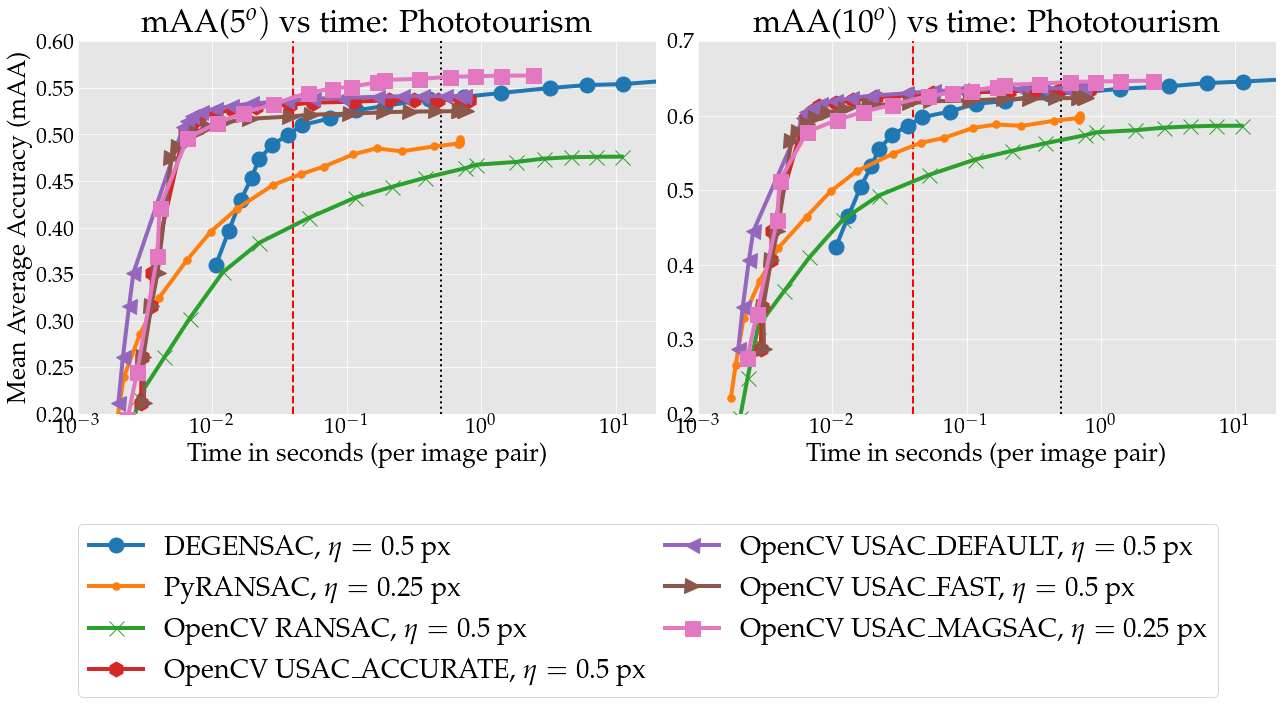

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('Dark2')
datasets = ['phototourism']#, 'googleurban', 'pragueparks']

feedback = {}
for cur, t in enumerate([5, 10]):
    ax = axes[cur]
    labels = []
    time_threshold = 0.5
    count = 0
    for i, method in enumerate(methods):
        cur_best_index, cur_best_val, cur_best_th, cur_best_t, best_map10 = -1, 0, 0, 0, 0
        x, y = [], []
        for j, max_iter in enumerate(max_iters):
            key = '{}, max_iter={}'.format(method, max_iter)
            if key in results:
                th = ''
                t_geom = 0
                v_map5 = 0
                v_map10 = 0
                for oo, dset in enumerate(datasets):
                    th += str(results[key]['config'][f'config_{dset}_stereo']['geom']['threshold'])
                    #if oo < 2:
                    #    th+=', '
                    t_geom += results[key][dset]['results']['allseq']['stereo']['run_avg']['geom_cost']['mean']

                    v_map5 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_05_th_0.1']['mean']
                    v_map10 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_10_th_0.1']['mean']
                t_geom = t_geom / float(len(datasets))
                v_map5 = v_map5 / float(len(datasets))
                v_map10 = v_map10 / float(len(datasets))
                
                x.append(t_geom)
                y.append(v_map10 if t == 10 else v_map5)

                if cur == 0 and (v_map5 + v_map10) / 2 > cur_best_val and t_geom < time_threshold:
                    cur_best_index = j
                    cur_best_val = (v_map5 + v_map10) / 2
                    cur_best_map10 = v_map10
                    cur_best_t = t_geom
                    cur_best_th = th
        if len(x) > 0:
            ax.semilogx(x, y, '-', marker=markers[i], markersize=15, c=cmap(count), linewidth=defaults['line_width'] + 1)
            # cur_label = '{} ({})'.format(key.split(',')[0], key.split(',')[1][1:])
            kkey = key.split(',')[0]
            print (kkey)
            cur_label = methods[kkey]
            cur_th = float(key.split(',')[1][1:].split('=')[-1])
            cur_label = '{}, $\\eta={}$ px'.format(cur_label, th)
            labels.append(cur_label)
            count += 1
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title('mAA({}$^o)$ vs time: Phototourism'.format(t), fontsize=defaults['font_size_title'], pad=10)
    ax.set_xlabel('Time in seconds (per image pair)', fontsize=defaults['font_size_axes'])
    if t == 5:
        ax.set_ylabel('Mean Average Accuracy (mAA)', fontsize=defaults['font_size_axes'])
    ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])

    lims = (0.2, 0.7)  if t == 10 else (0.2, 0.6)
#     lims = (0.45, 0.71)
    ax.set_ylim(lims)
    ax.vlines(0.5, lims[0], lims[1], lw=2, color='k', linestyle=':')
    ax.vlines(1.0/25., lims[0], lims[1], lw=2, color='r', linestyle='--')
    ax.set_xlim(1e-3, 20)
    make_like_colab(fig, ax)

for i in sorted(feedback.keys())[::-1]:
    print(feedback[i])
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.42)
fig.legend(labels, prop={'size': defaults['font_size_legend'] + 5}, columnspacing=0.67, loc='lower center', bbox_to_anchor=(0.5, -0.), ncol=2)
plt.savefig('sac-map-vs-cost-both-maps-log-phototourism.pdf', bbox_inches='tight', dpi=defaults['dpi'])
plt.show()

cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f
cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f


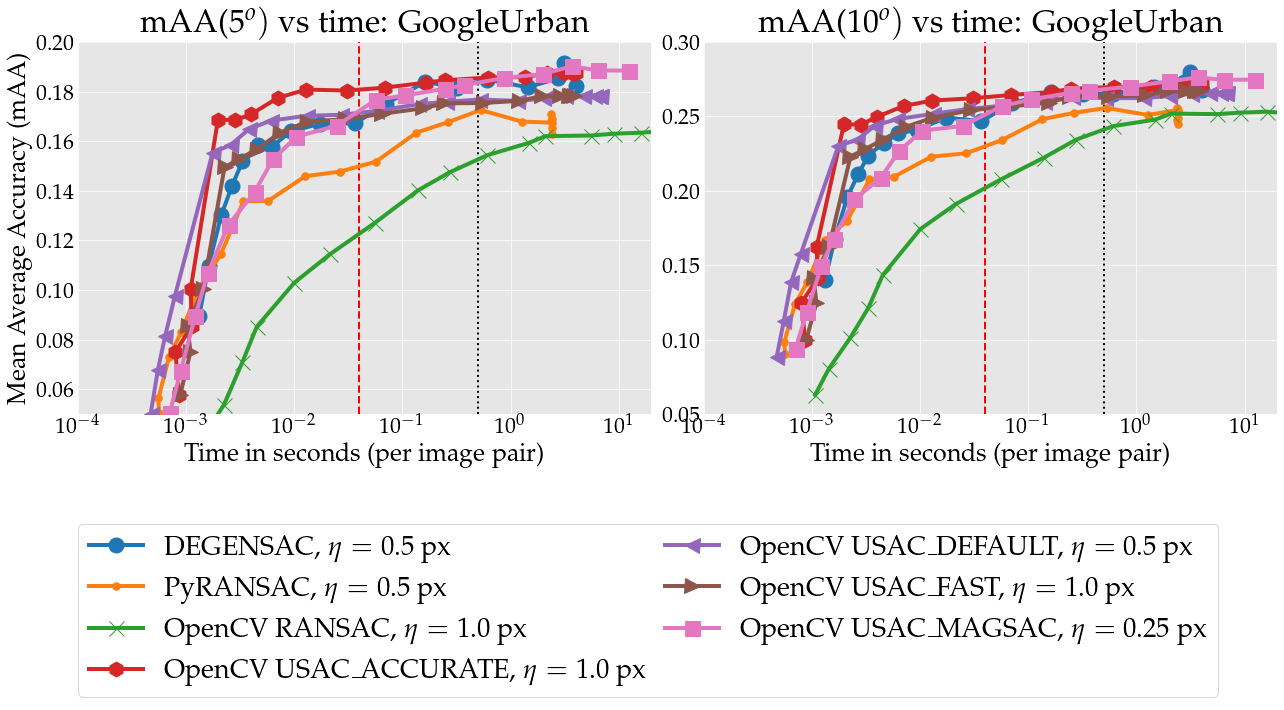

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('Dark2')
datasets = ['googleurban']#, 'googleurban', 'pragueparks']

feedback = {}
for cur, t in enumerate([5, 10]):
    ax = axes[cur]
    labels = []
    time_threshold = 0.5
    count = 0
    for i, method in enumerate(methods):
        cur_best_index, cur_best_val, cur_best_th, cur_best_t, best_map10 = -1, 0, 0, 0, 0
        x, y = [], []
        for j, max_iter in enumerate(max_iters):
            key = '{}, max_iter={}'.format(method, max_iter)
            if key in results:
                th = ''
                t_geom = 0
                v_map5 = 0
                v_map10 = 0
                for oo, dset in enumerate(datasets):
                    th += str(results[key]['config'][f'config_{dset}_stereo']['geom']['threshold'])
                    #if oo < 2:
                    #    th+=', '
                    t_geom += results[key][dset]['results']['allseq']['stereo']['run_avg']['geom_cost']['mean']

                    v_map5 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_05_th_0.1']['mean']
                    v_map10 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_10_th_0.1']['mean']
                t_geom = t_geom / float(len(datasets))
                v_map5 = v_map5 / float(len(datasets))
                v_map10 = v_map10 / float(len(datasets))
                
                x.append(t_geom)
                y.append(v_map10 if t == 10 else v_map5)

                if cur == 0 and (v_map5 + v_map10) / 2 > cur_best_val and t_geom < time_threshold:
                    cur_best_index = j
                    cur_best_val = (v_map5 + v_map10) / 2
                    cur_best_map10 = v_map10
                    cur_best_t = t_geom
                    cur_best_th = th
        if len(x) > 0:
            ax.semilogx(x, y, '-', marker=markers[i], markersize=15, c=cmap(count), linewidth=defaults['line_width'] + 1)
            # cur_label = '{} ({})'.format(key.split(',')[0], key.split(',')[1][1:])
            kkey = key.split(',')[0]
            print (kkey)
            cur_label = methods[kkey]
            cur_th = float(key.split(',')[1][1:].split('=')[-1])
            cur_label = '{}, $\\eta={}$ px'.format(cur_label, th)
            labels.append(cur_label)
            count += 1
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title('mAA({}$^o)$ vs time: GoogleUrban'.format(t), fontsize=defaults['font_size_title'], pad=10)
    
    ax.set_xlabel('Time in seconds (per image pair)', fontsize=defaults['font_size_axes'])
    if t == 5:
        ax.set_ylabel('Mean Average Accuracy (mAA)', fontsize=defaults['font_size_axes'])
    ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])

    lims = (0.05, 0.3)  if t == 10 else (0.05, 0.2)
#     lims = (0.45, 0.71)
    ax.set_ylim(lims)
    ax.vlines(0.5, lims[0], lims[1], lw=2, color='k', linestyle=':')
    ax.vlines(1.0/25., lims[0], lims[1], lw=2, color='r', linestyle='--')
    ax.set_xlim(1e-4, 20)
    make_like_colab(fig, ax)

for i in sorted(feedback.keys())[::-1]:
    print(feedback[i])
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.42)
fig.legend(labels, prop={'size': defaults['font_size_legend'] + 5}, columnspacing=0.67, loc='lower center', bbox_to_anchor=(0.5, -0.), ncol=2)
plt.savefig('sac-map-vs-cost-both-maps-log-googleurban.pdf', bbox_inches='tight', dpi=defaults['dpi'])
plt.show()

cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f
cmp-degensac-f
nodegen
cv2-ransac-f
cv2-usacaccurate-f
cv2-usacdef-f
cv2-usacfast-f
cv2-usacmagsac-f


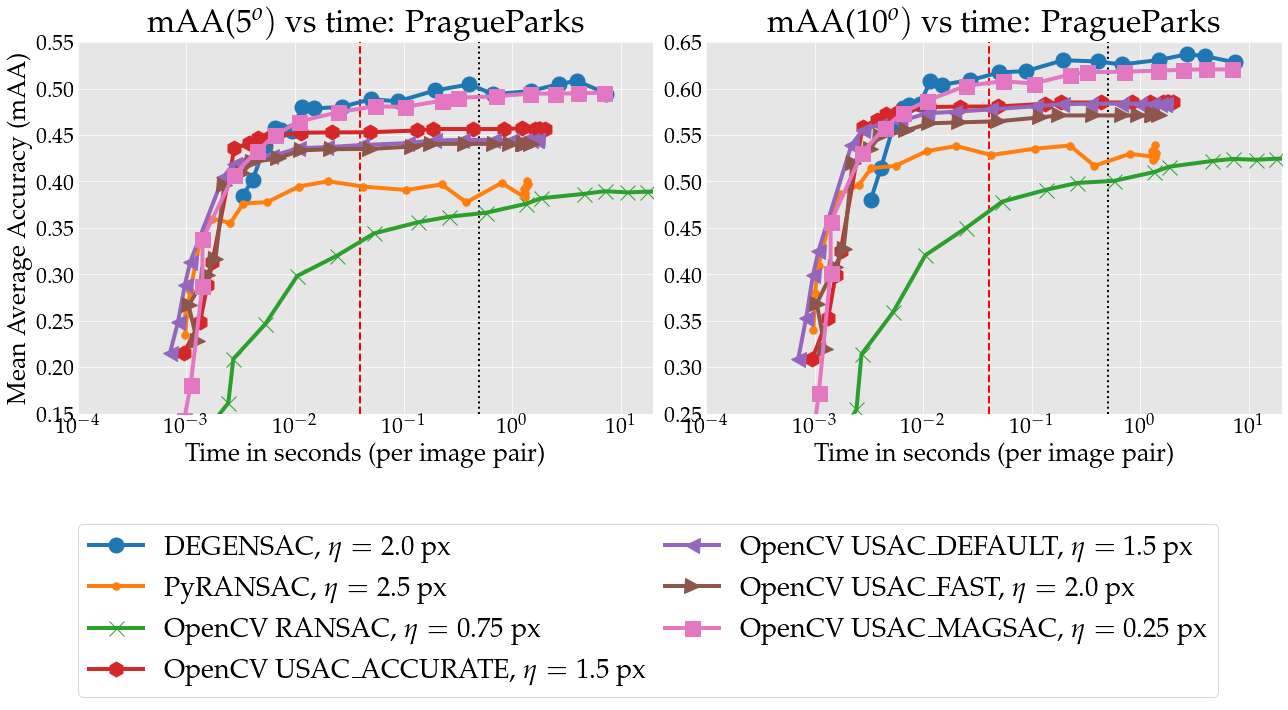

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('Dark2')
datasets = ['pragueparks']#, 'googleurban', 'pragueparks']

feedback = {}
for cur, t in enumerate([5, 10]):
    ax = axes[cur]
    labels = []
    time_threshold = 0.5
    count = 0
    for i, method in enumerate(methods):
        cur_best_index, cur_best_val, cur_best_th, cur_best_t, best_map10 = -1, 0, 0, 0, 0
        x, y = [], []
        for j, max_iter in enumerate(max_iters):
            key = '{}, max_iter={}'.format(method, max_iter)
            if key in results:
                th = ''
                t_geom = 0
                v_map5 = 0
                v_map10 = 0
                for oo, dset in enumerate(datasets):
                    th += str(results[key]['config'][f'config_{dset}_stereo']['geom']['threshold'])
                    #if oo < 2:
                    #    th+=', '
                    t_geom += results[key][dset]['results']['allseq']['stereo']['run_avg']['geom_cost']['mean']

                    v_map5 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_05_th_0.1']['mean']
                    v_map10 += results[key][dset]['results']['allseq']['stereo']['run_avg']['qt_auc_10_th_0.1']['mean']
                t_geom = t_geom / float(len(datasets))
                v_map5 = v_map5 / float(len(datasets))
                v_map10 = v_map10 / float(len(datasets))
                
                x.append(t_geom)
                y.append(v_map10 if t == 10 else v_map5)

                if cur == 0 and (v_map5 + v_map10) / 2 > cur_best_val and t_geom < time_threshold:
                    cur_best_index = j
                    cur_best_val = (v_map5 + v_map10) / 2
                    cur_best_map10 = v_map10
                    cur_best_t = t_geom
                    cur_best_th = th
        if len(x) > 0:
            ax.semilogx(x, y, '-',  marker=markers[i], markersize=15, c=cmap(count), linewidth=defaults['line_width'] + 1)
            # cur_label = '{} ({})'.format(key.split(',')[0], key.split(',')[1][1:])
            kkey = key.split(',')[0]
            print (kkey)
            cur_label = methods[kkey]
            cur_th = float(key.split(',')[1][1:].split('=')[-1])
            cur_label = '{}, $\\eta={}$ px'.format(cur_label, th)
            labels.append(cur_label)
            count += 1
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title('mAA({}$^o)$ vs time: PragueParks'.format(t), fontsize=defaults['font_size_title'], pad=10)
    ax.set_xlabel('Time in seconds (per image pair)', fontsize=defaults['font_size_axes'])
    if t == 5:
        ax.set_ylabel('Mean Average Accuracy (mAA)', fontsize=defaults['font_size_axes'])
    ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])

    lims = (0.25, 0.65)  if t == 10 else (0.15, 0.55)
#     lims = (0.45, 0.71)
    ax.set_ylim(lims)
    ax.vlines(0.5, lims[0], lims[1], lw=2, color='k', linestyle=':')
    ax.vlines(1.0/25., lims[0], lims[1], lw=2, color='r', linestyle='--')
    ax.set_xlim(1e-4, 20)
    make_like_colab(fig, ax)

for i in sorted(feedback.keys())[::-1]:
    print(feedback[i])
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.42)
fig.legend(labels, prop={'size': defaults['font_size_legend'] + 5}, columnspacing=0.67, loc='lower center', bbox_to_anchor=(0.5, -0.), ncol=2)
plt.savefig('sac-map-vs-cost-both-maps-log-pragueparks.pdf', bbox_inches='tight', dpi=defaults['dpi'])
plt.show()